# XGBoost R

## What XGBoost does
- gradient boosted decision trees for tabular data
- works for regression (numeric target) and classification (binary or multiclass)
- trains an ensemble of small trees, each correcting the previous ones

## Prepare the data
- XGBoost expects a numeric feature matrix. Convert factors to one-hot columns (single 1 and zeros in vector)
- in R, use `Matrix::sparse.model.matrix(~ . - 1, data)` to one-hot encode and drop the intercept
- labels:
  - regression: numeric vector
  - binary class: labels as 0 and 1
  - multiclass: labels as integers in 0..K-1
- use `xgb.DMatrix(data = feature_matrix, label = y, missing = NA)` for efficient training

## defaults
- `objective`:
  - regression: `"reg:squarederror"`
  - binary: `"binary:logistic"`
  - multiclass: `"multi:softprob"` and set `num_class`
- `eval_metric`:
  - regression: `"rmse"`
  - binary: `"logloss"` (optionally `"auc"`)
  - multiclass: `"mlogloss"`
- regularization and complexity:
  - `eta` (learning rate): 0.05 to 0.2
  - `max_depth`: 4 to 8 for tabular data
  - `subsample`, `colsample_bytree`: 0.6 to 0.9 to reduce overfit
  - `min_child_weight` (increase to smooth noisy data)
- use `watchlist` with train and test and `early_stopping_rounds` to stop before overfitting

## evaluate and visualize
- training curves: `model$evaluation_log` gives metric by iteration
- regression: plot predicted vs actual and compute RMSE or MAE
- classification: compute accuracy and confusion matrix. For binary, threshold at 0.5
- feature importance: `xgb.importance` then draw a simple barplot

## pitfalls
- forgetting to one-hot encode factors before training
- multiclass labels must start at 0
- train and test matrices must have the same columns in the same order. Build a single design matrix from the combined rows then split back into train and test
- use early stopping. Large `nrounds` without early stopping will overfit

## alternatives
- `lightgbm` and `catboost` also perform very well on tabular data
- `tidymodels` (parsnip, workflows) can wrap XGBoost for pipelines


In [1]:
library(xgboost)
library(Matrix)

In [6]:
n = 1200
numeric_one = rnorm(n)
numeric_two = runif(n, -2, 2)
group = factor(sample(c("A","B","C"), n, replace = TRUE))
noise = rnorm(n, sd = 0.7)


In [8]:
y_reg = 5 + 3 * numeric_one - 2 * numeric_two + ifelse(group == "B", 2, ifelse(group == "C", -3, 0)) + noise


In [9]:
df_reg = data.frame(y_reg = y_reg, numeric_one = numeric_one, numeric_two = numeric_two, group = group)


In [10]:
train_index = sample(seq_len(nrow(df_reg)), size = floor(0.8 * nrow(df_reg)))

test_index = setdiff(seq_len(nrow(df_reg)), train_index)


In [19]:
# one-hot encode with a single sparse model matrix so columns line up
design_reg = sparse.model.matrix(y_reg ~ . - 1, data = df_reg)

y_all_reg  = df_reg$y_reg


In [21]:

X_train_reg = design_reg[train_index, ]
X_test_reg = design_reg[test_index, ]

y_train_reg = y_all_reg[train_index]
y_test_reg = y_all_reg[test_index]


In [23]:
dtrain_reg = xgb.DMatrix(data = X_train_reg, label = y_train_reg, missing = NA)

dtest_reg = xgb.DMatrix(data = X_test_reg,  label = y_test_reg,  missing = NA)


In [24]:
# parameters 
params_reg = list( objective = "reg:squarederror", eval_metric = "rmse",
  eta = 0.1, max_depth = 6,
  subsample = 0.8, colsample_bytree = 0.8
)

In [25]:
watchlist_reg = list(train = dtrain_reg, test = dtest_reg) #early stopping

In [26]:

model_reg = xgb.train(params = params_reg, data = dtrain_reg,
  nrounds = 500, watchlist = watchlist_reg,
  early_stopping_rounds = 25, verbose = 0
)

model_reg

##### xgb.Booster
raw: 271.9 Kb 
call:
  xgb.train(params = params_reg, data = dtrain_reg, nrounds = 500, 
    watchlist = watchlist_reg, verbose = 0, early_stopping_rounds = 25)
params (as set within xgb.train):
  objective = "reg:squarederror", eval_metric = "rmse", eta = "0.1", max_depth = "6", subsample = "0.8", colsample_bytree = "0.8", validate_parameters = "TRUE"
xgb.attributes:
  best_iteration, best_msg, best_ntreelimit, best_score, niter
callbacks:
  cb.evaluation.log()
  cb.early.stop(stopping_rounds = early_stopping_rounds, maximize = maximize, 
    verbose = verbose)
# of features: 5 
niter: 79
best_iteration : 54 
best_ntreelimit : 54 
best_score : 0.8160822 
best_msg : [54]	train-rmse:0.464668	test-rmse:0.816082 
nfeatures : 5 
evaluation_log:
  iter train_rmse test_rmse
 <num>      <num>     <num>
     1  5.5243265 5.1020933
     2  5.0724603 4.6891493
   ---        ---       ---
    78  0.4008267 0.8195341
    79  0.3980870 0.8214669

In [27]:
model_reg$best_iteration

[1] 54

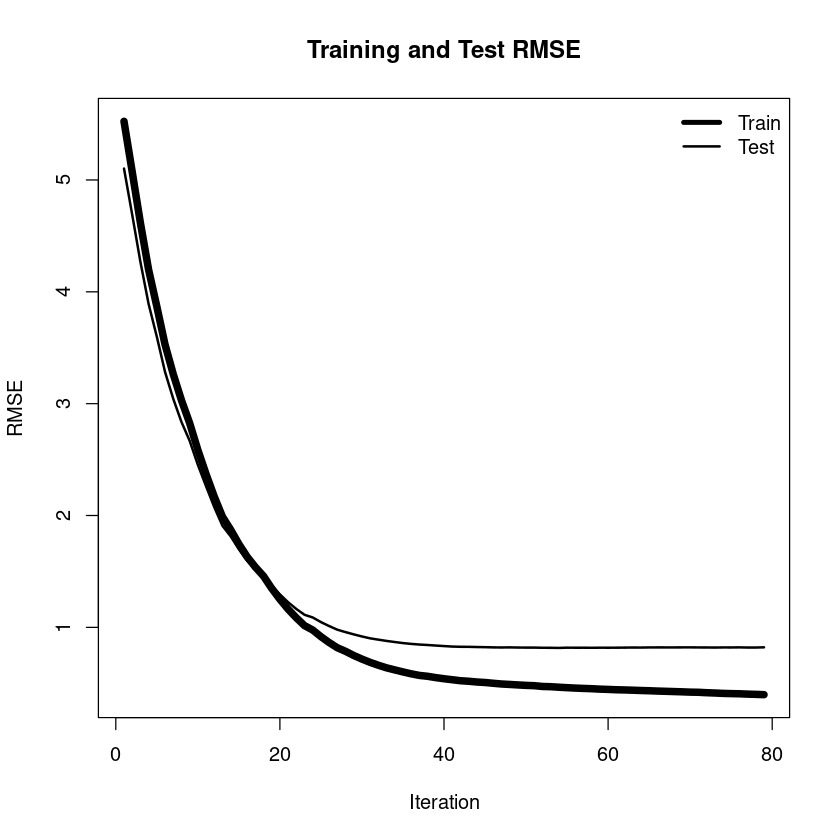

In [31]:
log_reg = model_reg$evaluation_log

plot(log_reg$iter, log_reg$train_rmse, type = "l", lwd = 6, 
     xlab = "Iteration", ylab = "RMSE", main = "Training and Test RMSE")

lines(log_reg$iter, log_reg$test_rmse, lwd = 2)

legend("topright", legend = c("Train","Test"), lty = c(1,1), lwd = c(4,2), bty = "n")

In [32]:
pred_reg = predict(model_reg, dtest_reg)
rmse = sqrt(mean((pred_reg - y_test_reg)^2))
mae = mean(abs(pred_reg - y_test_reg))

cat("RMSE:", round(rmse, 4), "  MAE:", round(mae, 4))

RMSE: 0.8161   MAE: 0.6545

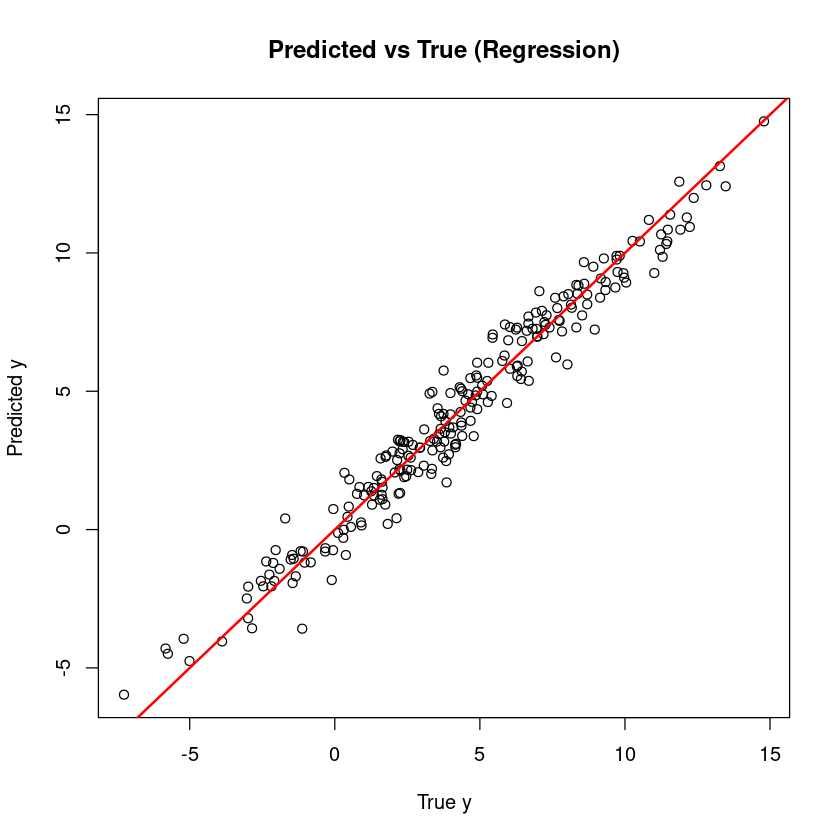

In [33]:

plot(y_test_reg, pred_reg,
     xlab = "True y", ylab = "Predicted y",
     main = "Predicted vs True (Regression)")

abline(0, 1, col = "red", lwd = 2)

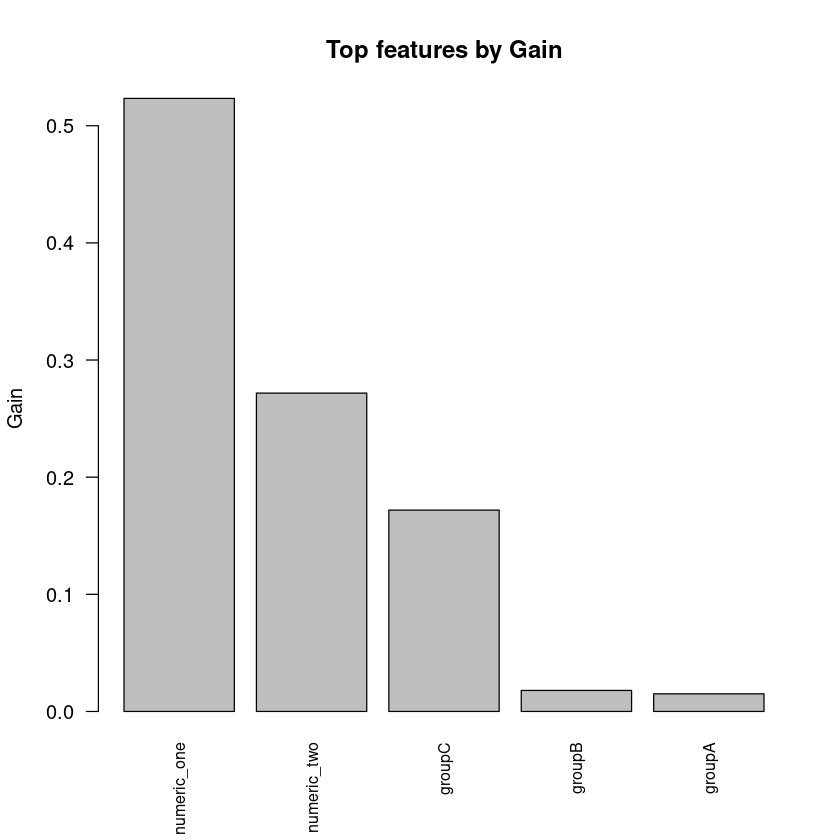

In [34]:
# feature importance (simple barplot without extra packages)
imp_reg = xgb.importance(feature_names = colnames(design_reg), model = model_reg)
# take top 10 by Gain
top_n = min(10, nrow(imp_reg))
imp_top = imp_reg[seq_len(top_n), ]

barplot(height = imp_top$Gain,
        names.arg = imp_top$Feature,
        las = 2, cex.names = 0.8,
        main = "Top features by Gain",
        ylab = "Gain")

# binary classification problem

In [38]:
# synthetic binary labels from a latent logit
n = 2000
x1 = rnorm(n)
x2 = runif(n, -1.5, 1.5)
grp = factor(sample(c("A","B","C","D"), n, replace = TRUE))
latent = 2 * x1 - 1.5 * x2 + ifelse(grp == "B", 0.8, ifelse(grp == "C", -0.8, 0)) + rnorm(n, sd = 0.8)

y_bin = ifelse(latent > 0, 1L, 0L)

In [39]:
df_bin = data.frame(y_bin = y_bin, x1 = x1, x2 = x2, grp = grp)

In [40]:
idx_train = sample(seq_len(nrow(df_bin)), size = floor(0.8 * nrow(df_bin)))

idx_test = setdiff(seq_len(nrow(df_bin)), idx_train)

In [41]:
# one-hot encode once
design_bin = sparse.model.matrix(y_bin ~ . - 1, data = df_bin)
y_all_bin = df_bin$y_bin

X_train_bin = design_bin[idx_train, ]
X_test_bin = design_bin[idx_test, ]

y_train_bin = y_all_bin[idx_train]
y_test_bin = y_all_bin[idx_test]

In [42]:
dtrain_bin = xgb.DMatrix(data = X_train_bin, label = y_train_bin)

dtest_bin = xgb.DMatrix(data = X_test_bin,  label = y_test_bin)

In [48]:
params_bin = list(
  objective = "binary:logistic",
  eval_metric = "logloss",
  eta = 0.1, max_depth = 7,
  subsample = 0.8, colsample_bytree = 0.8
)

In [49]:
watchlist_bin = list(train = dtrain_bin, test = dtest_bin)

In [54]:

model_bin = xgb.train( params = params_bin, data = dtrain_bin,
  nrounds = 900, watchlist = watchlist_bin,
  early_stopping_rounds = 150, verbose = 0
)

model_bin$best_iteration

[1] 75

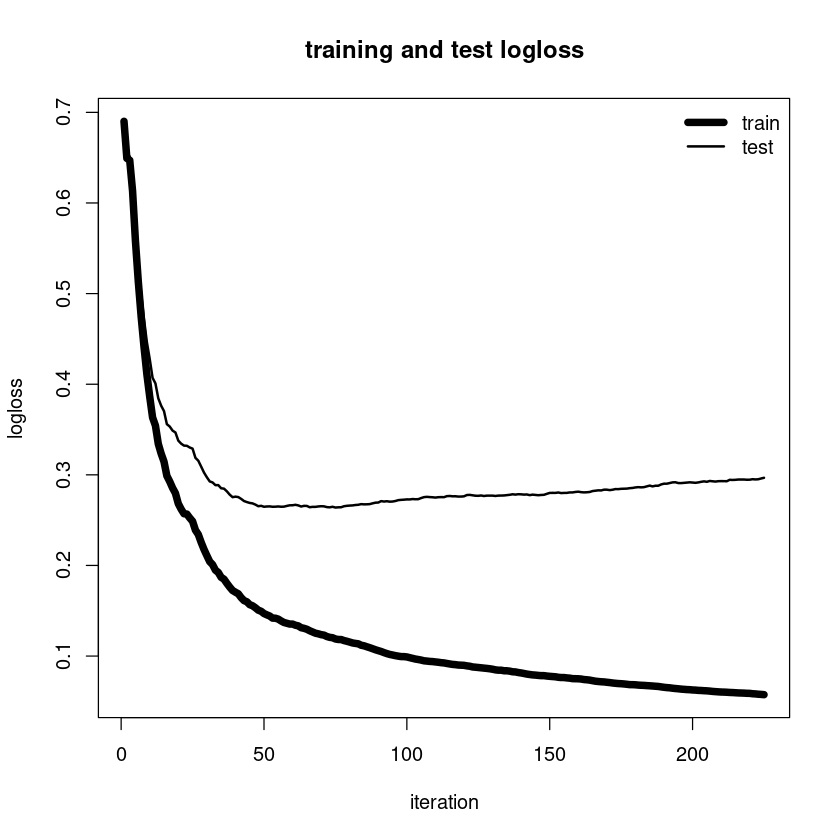

In [55]:
log_bin = model_bin$evaluation_log

plot(log_bin$iter, log_bin$train_logloss, type = "l", lwd = 6,
     xlab = "iteration", ylab = "logloss", main = "training and test logloss")

lines(log_bin$iter, log_bin$test_logloss, lwd = 2)
legend("topright", legend = c("train","test"), lty = c(1,1), lwd = c(6,2), bty = "n")

In [69]:
theta = 0.5
prob_bin = predict(model_bin, dtest_bin)
pred_bin = ifelse(prob_bin >= theta, 1L, 0L)

acc = mean(pred_bin == y_test_bin)

cat("Binary accuracy:", round(acc, 4))

Binary accuracy: 0.88

In [70]:
print(table(True = y_test_bin, Pred = pred_bin))

    Pred
True   0   1
   0 174  25
   1  23 178


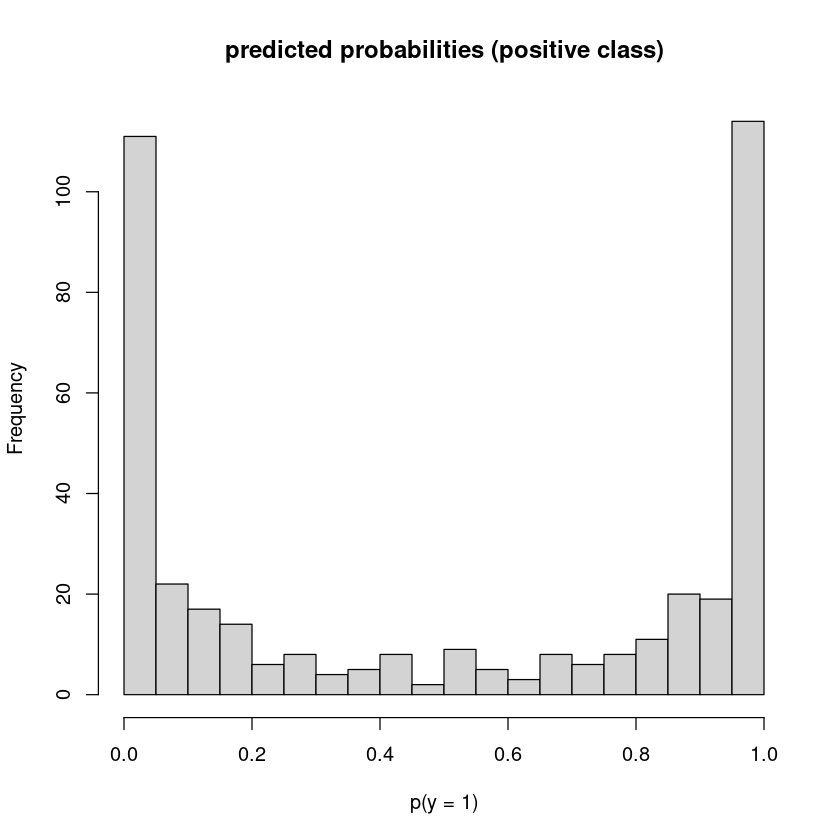

In [71]:
hist(prob_bin, breaks = 30, main = "predicted probabilities (positive class)", xlab = "p(y = 1)")

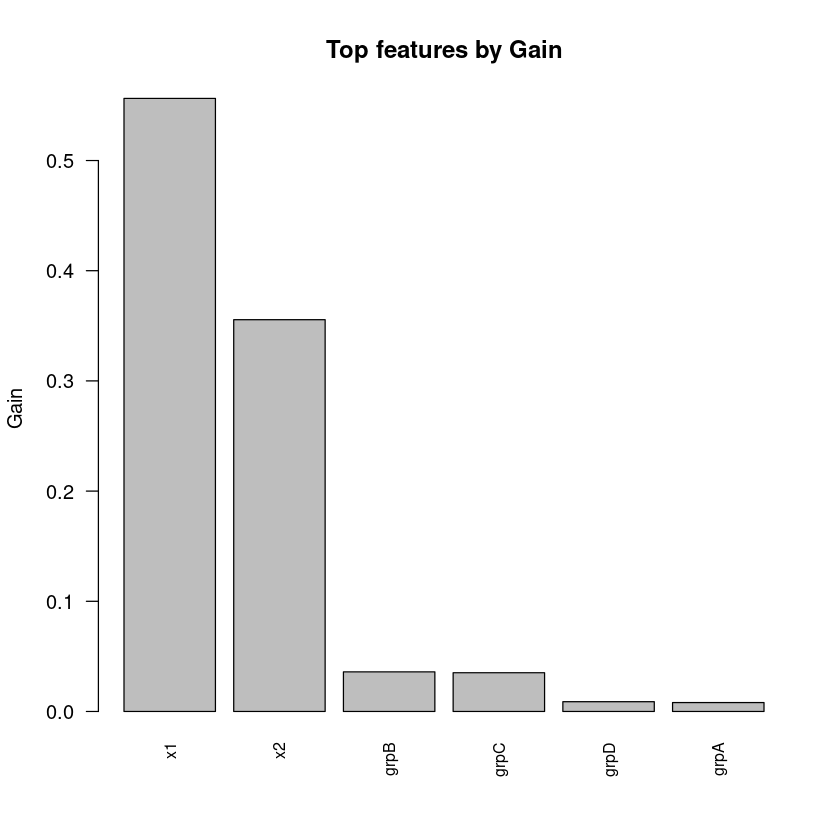

In [72]:
imp_bin = xgb.importance(feature_names = colnames(design_bin), model = model_bin)
top_n = min(10, nrow(imp_bin))
imp_top = imp_bin[seq_len(top_n), ]

barplot(height = imp_top$Gain, names.arg = imp_top$Feature,
        las = 2, cex.names = 0.8, main = "Top features by Gain", ylab = "Gain")

# regression

In [73]:
data(mtcars)
df = mtcars


In [74]:
df$cyl = factor(df$cyl)
df$vs = factor(df$vs)
df$am = factor(df$am)
df$gear = factor(df$gear)
df$carb = factor(df$carb)

In [75]:
train_rows = sample(seq_len(nrow(df)), size = floor(0.8 * nrow(df)))

test_rows = setdiff(seq_len(nrow(df)), train_rows)

In [76]:
# one-hot encode once; response on the left of formula
design_mtc = sparse.model.matrix(mpg ~ . - 1, data = df)
print(head(design_mtc))
y_all_mpg = df$mpg

6 x 17 sparse Matrix of class "dgCMatrix"


  [[ suppressing 17 column names ‘cyl4’, ‘cyl6’, ‘cyl8’ ... ]]



                                                                  
Mazda RX4         . 1 . 160 110 3.90 2.620 16.46 . 1 1 . . . 1 . .
Mazda RX4 Wag     . 1 . 160 110 3.90 2.875 17.02 . 1 1 . . . 1 . .
Datsun 710        1 . . 108  93 3.85 2.320 18.61 1 1 1 . . . . . .
Hornet 4 Drive    . 1 . 258 110 3.08 3.215 19.44 1 . . . . . . . .
Hornet Sportabout . . 1 360 175 3.15 3.440 17.02 . . . . 1 . . . .
Valiant           . 1 . 225 105 2.76 3.460 20.22 1 . . . . . . . .


In [77]:
X_train_mtc = design_mtc[train_rows, ]
X_test_mtc = design_mtc[test_rows, ]

y_train_mtc = y_all_mpg[train_rows]
y_test_mtc = y_all_mpg[test_rows]

In [78]:
dtrain_mtc = xgb.DMatrix(data = X_train_mtc, label = y_train_mtc)

dtest_mtc = xgb.DMatrix(data = X_test_mtc,  label = y_test_mtc)

In [79]:
params_mtc = list( objective = "reg:squarederror",
  eval_metric = "rmse", eta = 0.08,
  max_depth = 4, subsample = 0.9, colsample_bytree = 0.9
)

In [80]:
watchlist_mtc = list(train = dtrain_mtc, test = dtest_mtc)

In [81]:
model_mtc = xgb.train( params = params_mtc,
  data = dtrain_mtc, nrounds = 1000,
  watchlist = watchlist_mtc, early_stopping_rounds = 40,
  verbose = 0
)

In [82]:
pred_mtc = predict(model_mtc, dtest_mtc)
rmse_mtc = sqrt(mean((pred_mtc - y_test_mtc)^2))
mae_mtc = mean(abs(pred_mtc - y_test_mtc))

cat("mtcars RMSE:", round(rmse_mtc, 3), "  MAE:", round(mae_mtc, 3))

mtcars RMSE: 2.83   MAE: 2.534

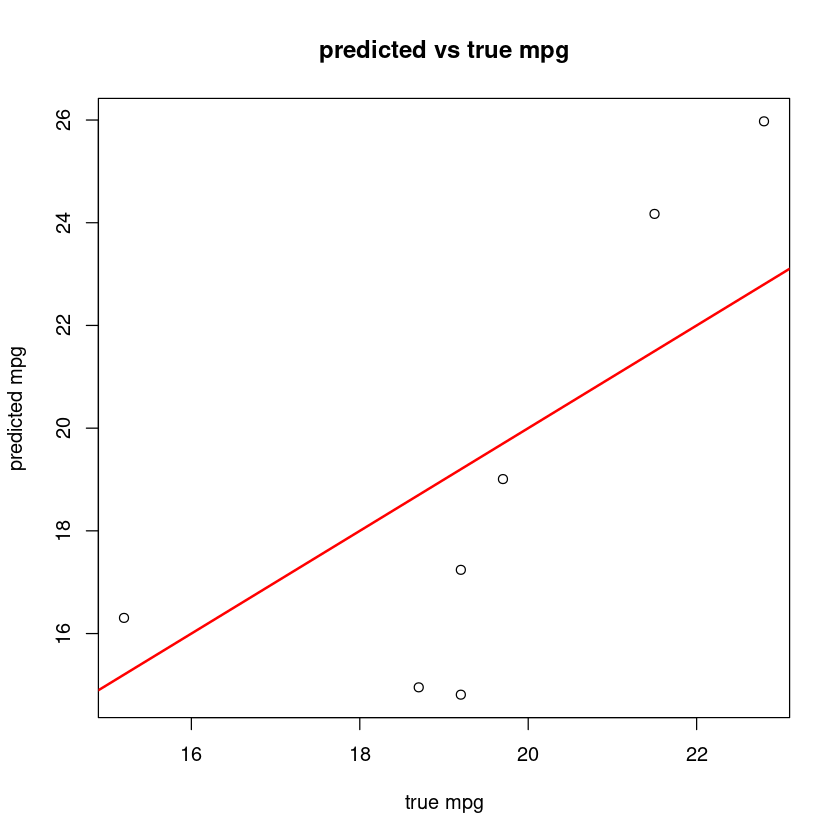

In [83]:

plot(y_test_mtc, pred_mtc,
     xlab = "true mpg", ylab = "predicted mpg",
     main = "predicted vs true mpg")

abline(0, 1, col = "red", lwd = 2)

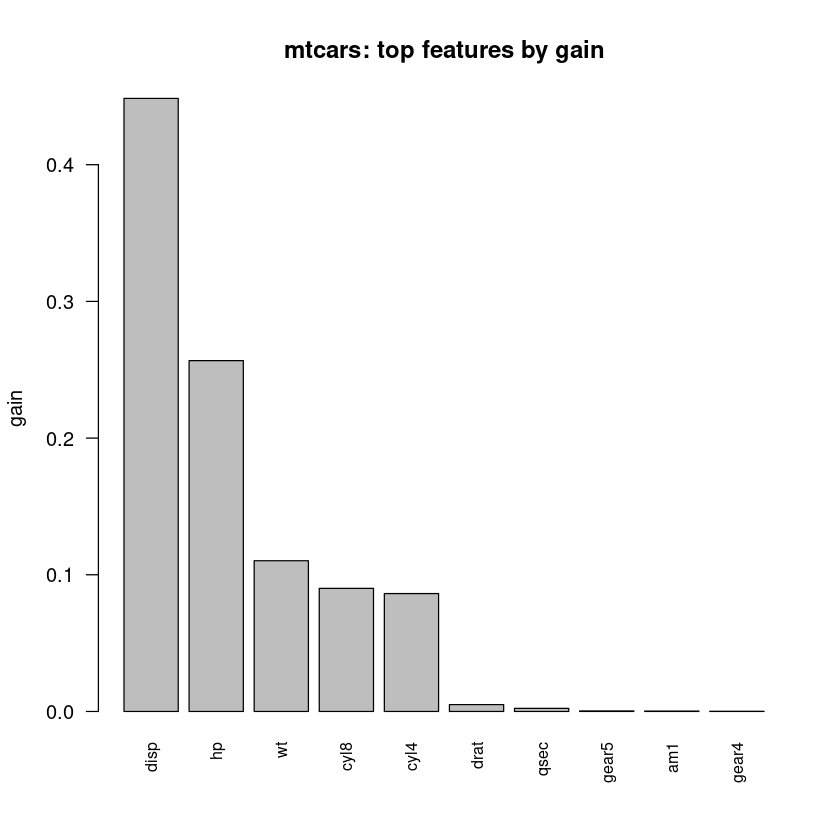

In [84]:
imp_mtc = xgb.importance(feature_names = colnames(design_mtc), model = model_mtc)
top_n = min(10, nrow(imp_mtc))
imp_top = imp_mtc[seq_len(top_n), ]

barplot(height = imp_top$Gain,
        names.arg = imp_top$Feature,
        las = 2, cex.names = 0.8,
        main = "mtcars: top features by gain",
        ylab = "gain")

# multiclass

In [85]:
data(iris)

In [86]:
X_all_iris = as.matrix(iris[, 1:4])

y_all_iris = as.integer(iris$Species) - 1L  # setosa -> 0, versicolor -> 1, virginica -> 2

In [89]:
unique(y_all_iris)

[1] 0 1 2

In [90]:

train_id = sample(seq_len(nrow(iris)), size = floor(0.8 * nrow(iris)))

test_id = setdiff(seq_len(nrow(iris)), train_id)

In [91]:

X_train_iris = X_all_iris[train_id, ]
X_test_iris = X_all_iris[test_id, ]
y_train_iris= y_all_iris[train_id]
y_test_iris = y_all_iris[test_id]

In [92]:

dtrain_iris = xgb.DMatrix(data = X_train_iris, label = y_train_iris)

dtest_iris = xgb.DMatrix(data = X_test_iris,  label = y_test_iris)

In [93]:

params_iris = list( objective = "multi:softprob",
  num_class = 3, eval_metric = "mlogloss",
  eta = 0.1, max_depth = 4,
  subsample = 0.9, colsample_bytree = 0.9
)


In [94]:
watchlist_iris = list(train = dtrain_iris, test = dtest_iris)

In [95]:

model_iris = xgb.train( params = params_iris,
  data = dtrain_iris, nrounds = 400,
  watchlist = watchlist_iris,
  early_stopping_rounds = 25, verbose = 0
)

In [96]:
prob_iris = matrix(predict(model_iris, dtest_iris), ncol = 3, byrow = TRUE)

pred_iris = max.col(prob_iris) - 1L


In [97]:

acc_iris = mean(pred_iris == y_test_iris)

cat("iris multiclass accuracy:", round(acc_iris, 4) )


iris multiclass accuracy: 0.9

In [99]:
cm = table(True = y_test_iris, Pred = pred_iris)
print(cm)


    Pred
True  0  1  2
   0 12  0  0
   1  0  5  3
   2  0  0 10


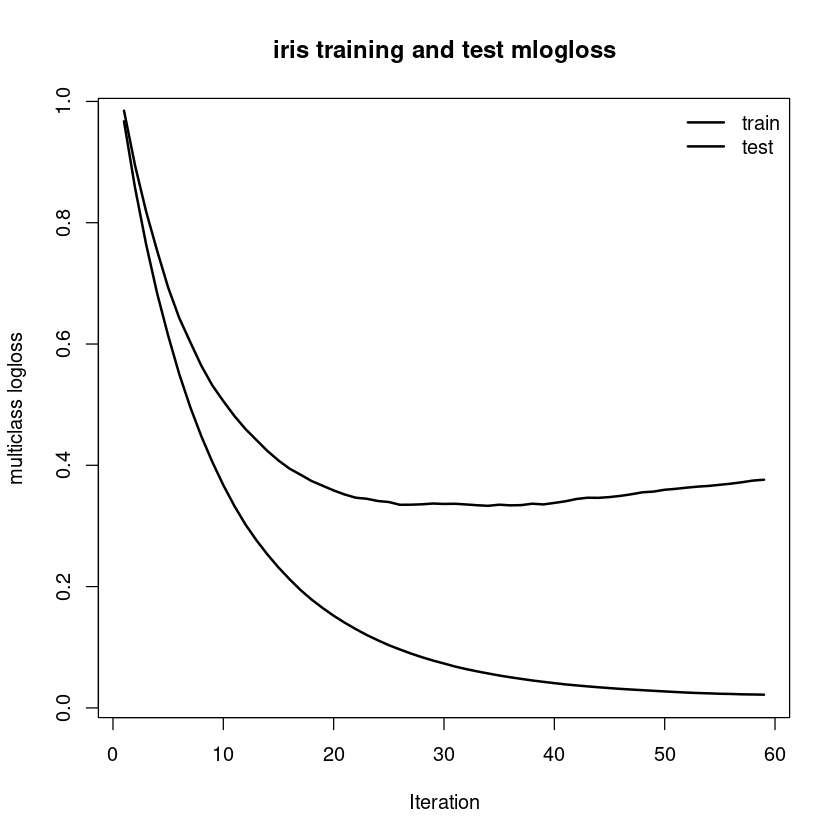

In [100]:
log_iris = model_iris$evaluation_log

plot(log_iris$iter, log_iris$train_mlogloss, type = "l", lwd = 2,
     xlab = "Iteration", ylab = "multiclass logloss", main = "iris training and test mlogloss")

lines(log_iris$iter, log_iris$test_mlogloss, lwd = 2)
legend("topright", legend = c("train","test"), lty = c(1,1), lwd = 2, bty = "n")


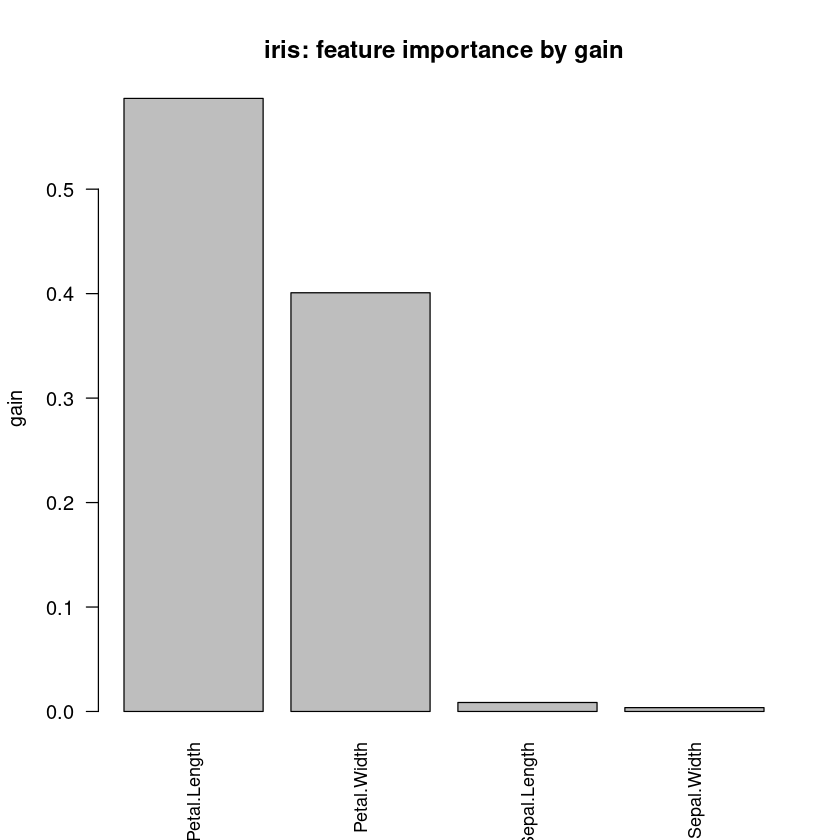

In [101]:
imp_iris = xgb.importance(model = model_iris, feature_names = colnames(X_all_iris))

top_n = min(4, nrow(imp_iris))

barplot(imp_iris$Gain[seq_len(top_n)],
        names.arg = imp_iris$Feature[seq_len(top_n)],
        las = 2, cex.names = 0.9,
        main = "iris: feature importance by gain",
        ylab = "gain")
